## Prerequisites
You need to install the following libraries to run codes in this article.

1. GridDB C Client
2. GridDB Python client

To install these libraries, follow the installation instructions on [GridDB Python Package Index (Pypi)](https://pypi.org/project/griddb-python/).

Since the code is executed in [Google Colab](https://colab.research.google.com/), you do not need to install any other libraries.

Run the following script to import required libraries into your Python application.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,  classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import griddb_python as griddb

2024-10-29 14:13:56.464516: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 14:13:56.475264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 14:13:56.486668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 14:13:56.490041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 14:13:56.498981: I tensorflow/core/platform/cpu_feature_guar

## Inserting IoT Data into GridDB

### Downloading and Importing the IoT Dataset From Kaggle

In [ ]:
# Dataset download link
#https://www.kaggle.com/datasets/subhajournal/iotintrusion/data

dataset = pd.read_csv("IoT_Intrusion.csv")
print(f"The dataset consists of {dataset.shape[0]} rows and {dataset.shape[1]} columns")
dataset.head()

The dataset consists of 1048575 rows and 47 columns


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1,0,1,...,0.000000,54.00,83343831.92,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0,0,0,...,2.822973,57.04,82926067.47,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0,0,0,...,0.000000,42.00,83127993.93,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0,0,0,...,0.000000,50.00,83015696.38,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0,1,0,...,23.113111,57.88,82972999.18,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


In [ ]:
dataset = dataset.sample(n=200000, random_state=42)
print(f"The dataset consists of {dataset.shape[0]} rows and {dataset.shape[1]} columns")
print(f"The total number of output labels are {dataset['label'].nunique()}")
dataset['label'].value_counts()

The dataset consists of 200000 rows and 47 columns
The total number of output labels are 34


label
DDoS-ICMP_Flood            30662
DDoS-UDP_Flood             23085
DDoS-TCP_Flood             19478
DDoS-SYN_Flood             17688
DDoS-PSHACK_Flood          17659
DDoS-RSTFINFlood           17088
DDoS-SynonymousIP_Flood    15432
DoS-UDP_Flood              14390
DoS-TCP_Flood              11310
DoS-SYN_Flood               8645
BenignTraffic               4571
Mirai-greeth_flood          4251
Mirai-udpplain              3792
Mirai-greip_flood           3266
DDoS-ICMP_Fragmentation     1954
MITM-ArpSpoofing            1372
DDoS-UDP_Fragmentation      1218
DDoS-ACK_Fragmentation      1174
DNS_Spoofing                 743
Recon-HostDiscovery          579
Recon-OSScan                 413
Recon-PortScan               373
DoS-HTTP_Flood               333
VulnerabilityScan            148
DDoS-HTTP_Flood              109
DDoS-SlowLoris                94
DictionaryBruteForce          57
SqlInjection                  32
BrowserHijacking              23
CommandInjection              23
XSS 

In [ ]:
category_map = {
    'DDoS': [
        'DDoS-ICMP_Flood', 'DDoS-UDP_Flood', 'DDoS-TCP_Flood', 'DDoS-PSHACK_Flood',
        'DDoS-SYN_Flood', 'DDoS-RSTFINFlood', 'DDoS-SynonymousIP_Flood', 'DDoS-ICMP_Fragmentation',
        'DDoS-ACK_Fragmentation', 'DDoS-UDP_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-SlowLoris'
    ],
    'DoS': [
        'DoS-UDP_Flood', 'DoS-TCP_Flood', 'DoS-SYN_Flood', 'DoS-HTTP_Flood'
    ],
    'Brute Force': [
        'DictionaryBruteForce'
    ],
    'Spoofing': [
        'MITM-ArpSpoofing', 'DNS_Spoofing'
    ],
    'Recon': [
        'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan', 'Recon-PingSweep'
    ],
    'Web-based': [
        'SqlInjection', 'CommandInjection', 'XSS', 'BrowserHijacking', 'Uploading_Attack'
    ],
    'Mirai': [
        'Mirai-greeth_flood', 'Mirai-udpplain', 'Mirai-greip_flood'
    ],
    'Other': [
        'VulnerabilityScan', 'Backdoor_Malware'
    ],
    'Benign-trafic': [
        'BenignTraffic'
    ]
}

# Reverse the mapping to allow lookup by subcategory
subcategory_to_parent = {subcat: parent for parent, subcats in category_map.items() for subcat in subcats}

# Add the 'class' column using the mapping
dataset['class'] = dataset['label'].map(subcategory_to_parent)

dataset['class'].value_counts()

class
DDoS             145641
DoS               34678
Mirai             11309
Benign-trafic      4571
Spoofing           2115
Recon              1375
Other               158
Web-based            96
Brute Force          57
Name: count, dtype: int64

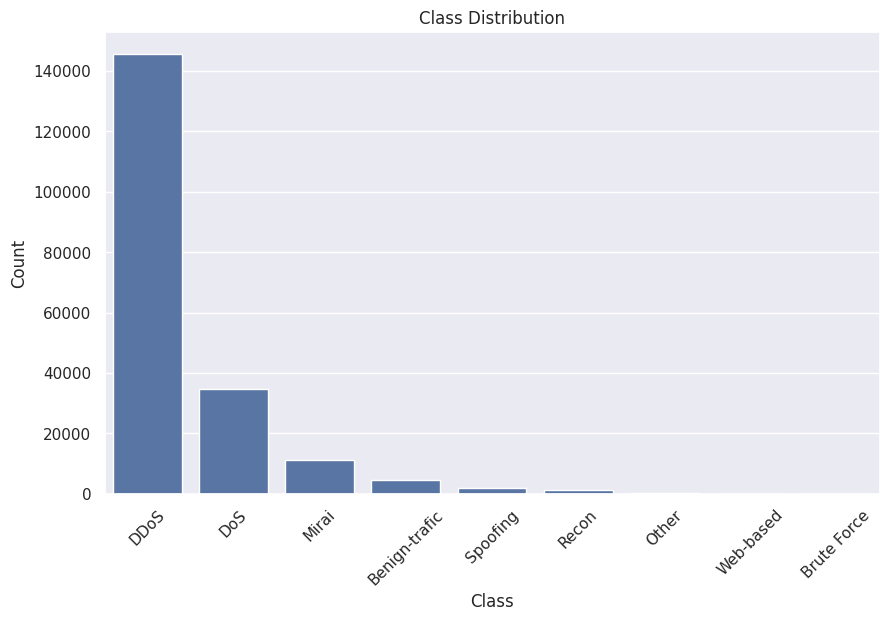

In [ ]:
class_counts = dataset['class'].value_counts()

sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Connect to GridDB

In [ ]:
# GridDB connection details
DB_HOST = "127.0.0.1:10001"
DB_CLUSTER = "myCluster"
DB_USER = "admin"
DB_PASS = "admin"

# creating a connection

factory = griddb.StoreFactory.get_instance()

try:
    gridstore = factory.get_store(
        notification_member = DB_HOST,
        cluster_name = DB_CLUSTER,
        username = DB_USER,
        password = DB_PASS
    )

    container1 = gridstore.get_container("container1")
    if container1 == None:
        print("Container does not exist")
    print("Successfully connected to GridDB")

except griddb.GSException as e:
    for i in range(e.get_error_stack_size()):
        print("[", i, "]")
        print(e.get_error_code(i))
        print(e.get_location(i))
        print(e.get_message(i))

Container does not exist
Successfully connected to GridDB


### Create Container for IoT Data in GridDB

In [ ]:
 # drop container if already exists
gridstore.drop_container("IoT_Data")

# Add an primary key column
dataset.insert(0, 'ID', range(1, len(dataset) + 1))

# Clean column names to remove spaces or forbidden characters in the GridDB container
dataset.columns = [col.strip().replace(" ", "_") for col in dataset.columns]

# Mapping from pandas data types to GridDB data types
type_mapping = {
    'float64': griddb.Type.DOUBLE,
    'int64': griddb.Type.INTEGER,
    'object': griddb.Type.STRING
}


# Generate column_info dynamically, adding ID as the first entry
column_info = [["ID", griddb.Type.INTEGER]] + [
    [col, type_mapping[str(dtype)]] for col, dtype in dataset.dtypes.items() if col != "ID"
]

# Define the container info with ID as the primary key and as a collection container
container_name = "IoT_Data"
container_info = griddb.ContainerInfo(
    container_name, column_info, griddb.ContainerType.COLLECTION, row_key=True
)

# Connecting to GridDB and creating the container
try:
    gridstore.put_container(container_info)
    container = gridstore.get_container(container_name)
    if container is None:
        print(f"Failed to create container: {container_name}")
    else:
        print(f"Successfully created container: {container_name}")

except griddb.GSException as e:
    print(f"Error creating container {container_name}:")
    for i in range(e.get_error_stack_size()):
        print(f"[{i}] Error code: {e.get_error_code(i)}, Message: {e.get_message(i)}")


Successfully created container: IoT_Data


### Insert IoT Data into GridDB

In [ ]:

try:
    for _, row in dataset.iterrows():
        # Prepare each row's data in the exact order as defined in `column_info`
        row_data = [
            int(row[col]) if dtype == griddb.Type.INTEGER else
            float(row[col]) if dtype == griddb.Type.DOUBLE else
            str(row[col])
            for col, dtype in column_info
        ]
        # Insert the row data into the container
        container.put(row_data)

    print(f"Successfully inserted {len(dataset)} rows of data into {container_name}")

except griddb.GSException as e:
    print(f"Error inserting data into container {container_name}:")
    for i in range(e.get_error_stack_size()):
        print(f"[{i}] Error code: {e.get_error_code(i)}, Message: {e.get_message(i)}")


Successfully inserted 200000 rows of data into IoT_Data


## Forecasting IoT Intrusion Using Machine Learning and Deep Learning

### Retrieving Data From GridDB

In [ ]:
def retrieve_data_from_griddb(container_name):

    try:
        data_container = gridstore.get_container(container_name)

        # Query all data from the container
        query = data_container.query("select *")
        rs = query.fetch()

        data = rs.fetch_rows()
        data .set_index("ID", inplace=True)
        return data

    except griddb.GSException as e:
        print(f"Error retrieving data from GridDB: {e.get_message()}")
        return None


iot_data = retrieve_data_from_griddb("IoT_Data")
iot_data.head()

,flow_duration,Header_Length,Protocol_Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Tot_size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,class
ID,,,,,,,,,,,,,,,,,,,,,
1,0.050452,29086.0,17.0,64.0,13847.636680,13847.636680,0.0,0,0,0,...,50.0,83097619.46,9.500000,10.000000,0.0,0.0,0.0,141.550000,DDoS-UDP_Flood,DDoS
2,0.000000,54.0,6.0,64.0,31.921397,31.921397,0.0,0,0,0,...,54.0,83067251.38,9.500000,10.392305,0.0,0.0,0.0,141.550000,DDoS-TCP_Flood,DDoS
3,0.000000,0.0,1.0,64.0,0.000000,0.000000,0.0,0,0,0,...,42.0,83128811.18,9.500000,9.165151,0.0,0.0,0.0,141.550000,DDoS-ICMP_Flood,DDoS
4,0.004086,6175.0,17.0,64.0,30305.458410,30305.458410,0.0,0,0,0,...,50.0,83016567.73,9.500000,10.000000,0.0,0.0,0.0,141.550000,DoS-UDP_Flood,DoS
5,0.000000,0.0,47.0,64.0,2.644189,2.644189,0.0,0,0,0,...,592.0,68779158.71,9.054795,34.409301,0.0,0.0,0.0,127.561644,Mirai-greeth_flood,Mirai


### IoT Data Classification Using Machine Learning

In [ ]:
# Separate the features (X) and the output class (y)

X = iot_data.drop(columns=['label', 'class'])  # Dropping both `label` and `class` columns as `class` is the target
y = iot_data['class']  # Output target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

classification_rep = classification_report(y_test, rf_predictions, zero_division=1)
print("Classification Report:\n", classification_rep)

Classification Report:
                precision    recall  f1-score   support

Benign-trafic       0.90      0.96      0.93       903
  Brute Force       1.00      0.00      0.00        10
         DDoS       1.00      1.00      1.00     29134
          DoS       1.00      1.00      1.00      6916
        Mirai       1.00      1.00      1.00      2298
        Other       0.85      0.57      0.68        30
        Recon       0.84      0.77      0.80       269
     Spoofing       0.87      0.83      0.85       428
    Web-based       1.00      0.00      0.00        12

     accuracy                           0.99     40000
    macro avg       0.94      0.68      0.70     40000
 weighted avg       0.99      0.99      0.99     40000



### IoT Data Classification Using Deep Learning

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(iot_data['class'])  # Integer encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Define the model
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(pd.unique(y)), activation='softmax')  # Softmax for multiclass classification
])

# Adaptive learning rate scheduler with exponential decay
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)

# Compile the model with Adam optimizer with decayed learning rate
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:

# Define callbacks without ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model with the callbacks
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7397 - loss: 0.7122 - val_accuracy: 0.8340 - val_loss: 0.3569
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8298 - loss: 0.3714 - val_accuracy: 0.8677 - val_loss: 0.3146
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8480 - loss: 0.3447 - val_accuracy: 0.8165 - val_loss: 0.3555
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8631 - loss: 0.3198 - val_accuracy: 0.7968 - val_loss: 0.3517
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8695 - loss: 0.3061 - val_accuracy: 0.8929 - val_loss: 0.2658
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8782 - loss: 0.2864 - val_accuracy: 0.8806 - val_loss: 0.2935
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8745 - loss: 0.2904 - val_accuracy: 0.8825 - val_loss: 0.2994
Epoch 8/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8850 - loss: 0

In [ ]:
# Load the best model
best_model = load_model('best_model.keras')

y_pred = best_model.predict(X_test).argmax(axis=-1)

print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82       903
           1       0.00      0.00      0.00        10
           2       0.90      0.98      0.94     29134
           3       0.84      0.55      0.67      6916
           4       1.00      0.99      1.00      2298
           5       0.60      0.50      0.55        30
           6       0.56      0.76      0.65       269
           7       0.90      0.39      0.54       428
           8       0.00      0.00      0.00        12

    accuracy                           0.89     40000
   macro avg       0.62      0.56      0.57     40000
weighted avg       0.89      0.89      0.88     40000

